In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
    
aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
# import node
# import link
# #import quadraticassignmentcyt
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [9]:
%%time
scenario = "Berlin-Center" #"Anaheim" #
num_iters = 5
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED  "berlin-center_net_clean_bpr_altered.tntp" #
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
bch.get_data_structure_with_by_directional_links()
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it


### Iterations
od_path_times = {}
shortest_path_time = 0
opt_setup_time = 0
opt_solv_time = 0
update_time = 0
total_time = 0
for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        t4 = time.time()
        t_assignment.update_path_flows(origin, solution)
        t5 = time.time()
        shortest_path_time += t2 - t1
        opt_setup_time += t3 - t2
        opt_solv_time += t4 - t3
        update_time += t5 - t4
        total_time += t5 - t1
        
    print(f"  {datetime.now()} - solved P(r) for all r and updated path flows")
    print(f"    runtime breakdown: dijkstra = {shortest_path_time:.2f}, opt setup = {opt_setup_time:.2f}, opt solver = {opt_solv_time:.2f}, update = {update_time:.2f}")
    print(f"                       dijkstra = {shortest_path_time/total_time:.0%}, opt setup = {opt_setup_time/total_time:.0%}, opt solver = {opt_solv_time/total_time:.0%}, update = {update_time/total_time:.0%}")
    

    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)
    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")
print(f"{datetime.now()} - Done")

# Collect results
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-06 11:21:00.585809 - Running scenario Berlin-Center
2020-12-06 11:21:01.363219 - num nodes = 12981, num links = 28370
2020-12-06 11:21:03.702927 - performing initial solution
  2020-12-06 11:21:14.532679 - starting iteration 0
  2020-12-06 11:21:49.540753 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 9.00, opt setup = 6.32, opt solver = 9.55, update = 10.12
                       dijkstra = 26%, opt setup = 18%, opt solver = 27%, update = 29%
  2020-12-06 11:21:49.740232 - computed path times and flows, computed gap: 0.03523369394561715, computed objective: 13572901.0
  2020-12-06 11:21:49.740372 - starting iteration 1
  2020-12-06 11:22:29.026531 - solved P(r) for all r and updated path flows
    runtime breakdown: dijkstra = 18.85, opt setup = 14.01, opt solver = 21.19, update = 20.23
                       dijkstra = 25%, opt setup = 19%, opt solver = 29%, update = 27%
  2020-12-06 11:22:29.236933 - computed path times and flows, computed g

In [10]:
%%time
bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 9min 38s, sys: 6.14 s, total: 9min 45s
Wall time: 1min 26s


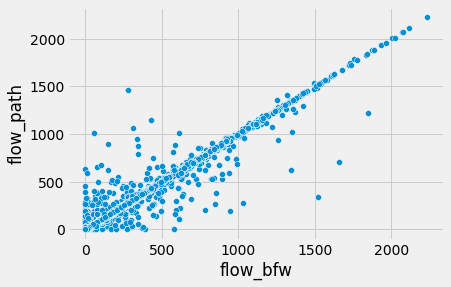

max diff in flow = 1177.1852388100478
max rel diff in flow = 1.833658672929291e-16


,link_id,a_node,b_node,ff_time,capacity,alpha,beta,direction,flow_bfw,flow_path,abs_change,rel_change
19490,19490,8720,413,0.0,999999.0,0.0,4.0,1,279.710269,1456.895508,1177.185239,4.208588
2092,2092,419,8720,0.0,999999.0,0.0,4.0,1,279.710269,1456.895508,1177.185239,4.208588
2090,2090,419,8426,0.0,999999.0,0.0,4.0,1,1520.484065,344.374115,1176.109950,0.773510
18848,18848,8426,413,0.0,999999.0,0.0,4.0,1,1520.484065,344.374115,1176.109950,0.773510
18849,18849,8426,419,0.0,999999.0,0.0,4.0,1,1658.772601,707.987366,950.785236,0.573186


In [11]:
d_ = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
#d_ = d_.drop(columns=['time_old', 'time_new'])
sns.scatterplot(data=d_, x='flow_bfw', y='flow_path');
plt.show();
d_['abs_change'] = np.abs(d_.flow_bfw - d_.flow_path)
d_['rel_change'] = d_['abs_change'] / d_['flow_bfw']
print(f"max diff in flow = {d_['abs_change'].max()}")
print(f"max rel diff in flow = {d_['rel_change'].min()}")
d_.sort_values(by=['abs_change'], ascending=False).head(5)

In [12]:
d_.sort_values(by=['abs_change'], ascending=False).head(20)

,link_id,a_node,b_node,ff_time,capacity,alpha,beta,direction,flow_bfw,flow_path,abs_change,rel_change
19490,19490,8720,413,0.0,999999.0,0.0,4.0,1,279.710269,1456.895508,1177.185239,4.208588
2092,2092,419,8720,0.0,999999.0,0.0,4.0,1,279.710269,1456.895508,1177.185239,4.208588
2090,2090,419,8426,0.0,999999.0,0.0,4.0,1,1520.484065,344.374115,1176.109950,0.773510
18848,18848,8426,413,0.0,999999.0,0.0,4.0,1,1520.484065,344.374115,1176.109950,0.773510
18849,18849,8426,419,0.0,999999.0,0.0,4.0,1,1658.772601,707.987366,950.785236,0.573186
2060,2060,413,8426,0.0,999999.0,0.0,4.0,1,1658.772601,707.987366,950.785236,0.573186
2061,2061,413,8720,0.0,999999.0,0.0,4.0,1,56.007703,1006.270874,950.263171,16.966651
19491,19491,8720,419,0.0,999999.0,0.0,4.0,1,56.007703,1006.270874,950.263171,16.966651
418,418,84,10750,0.0,999999.0,0.0,4.0,1,1027.799664,279.311218,748.488446,0.728244
22833,22833,10321,84,0.0,999999.0,0.0,4.0,1,945.914695,197.426300,748.488395,0.791285
